# import

In [ ]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=879140 sha256=309df293d4b156810d1da7fd8d2e4f1f383801ddb9b12bc4108587ae00e18abd
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [ ]:
import numpy as np
import pandas as pd
import tqdm
import re
from lightfm import LightFM

In [ ]:
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook
from collections import defaultdict
from tqdm.notebook import tqdm_notebook
from sklearn import preprocessing

## Предобработка данных

In [ ]:
books = pd.read_csv("BX-Books.csv",encoding='utf-8',sep = ',', on_bad_lines='skip', dtype=str)
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
140627,0151269300,Dutch Uncle,Marilyn Durham,1973,Harcourt,http://images.amazon.com/images/P/0151269300.0...,http://images.amazon.com/images/P/0151269300.0...,http://images.amazon.com/images/P/0151269300.0...
140628,0307161811,The E-Mail Mystery (Mercer Mayer's Lc + the Cr...,Erica Farber,1995,Golden Books,http://images.amazon.com/images/P/0307161811.0...,http://images.amazon.com/images/P/0307161811.0...,http://images.amazon.com/images/P/0307161811.0...
140629,0553157779,"Jack Galaxy, Space Cop",Robert Kraus,1989,Skylark Books,http://images.amazon.com/images/P/0553157779.0...,http://images.amazon.com/images/P/0553157779.0...,http://images.amazon.com/images/P/0553157779.0...
140630,0816737819,Sonic &amp; Knuckles,Michael Teitelbaum,1995,Troll Communications,http://images.amazon.com/images/P/0816737819.0...,http://images.amazon.com/images/P/0816737819.0...,http://images.amazon.com/images/P/0816737819.0...


In [ ]:
interactions = pd.read_csv("BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")
interactions = interactions[interactions["Book-Rating"] != 0]
interactions

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [ ]:
books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})
books_meets

,ISBN,user_num
0,0330299891,1
1,0375404120,1
2,9022906116,1
3,#6612432,1
4,'9607092910',1
...,...,...
185968,"\8888809228\""""",1
185969,"\9170010242\""""",1
185970,ooo7156103,1
185971,´3499128624,1


In [ ]:
user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})
user_meets

,User-ID,books_num
0,8,7
1,9,1
2,10,1
3,12,1
4,14,3
...,...,...
77800,278846,1
77801,278849,1
77802,278851,14
77803,278852,1


In [ ]:
interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])
interactions = interactions[(interactions["user_num"] > 5) &
                            (interactions["books_num"] > 5) &
                            (interactions["books_num"] < 200)]

In [ ]:
users = pd.read_csv('BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')
users

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [ ]:
from sklearn import preprocessing

interactions = interactions.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])

le = preprocessing.LabelEncoder()
interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["User-ID"])
interactions

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url_x,Book-Title_x,picture_url_y,Book-Title_y,product_id,vid,picture_url,Book-Title
0,86583,3404139178,9,8,18,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10377,3444,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman
1,132500,3404139178,10,8,43,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10377,5247,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman
2,66483,3404139178,10,8,83,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10377,2622,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman
3,276866,3404139178,9,8,11,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10377,10882,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman
4,106534,3404139178,6,8,6,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman,10377,4227,http://images.amazon.com/images/P/3404139178.0...,Das Lacheln der Fortuna: Historischer Roman
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110419,27551,0849912970,10,6,6,http://images.amazon.com/images/P/0849912970.0...,Traveling Light: Releasing the Burdens You Wer...,http://images.amazon.com/images/P/0849912970.0...,Traveling Light: Releasing the Burdens You Wer...,9461,1035,http://images.amazon.com/images/P/0849912970.0...,Traveling Light: Releasing the Burdens You Wer...
110420,206652,1860465811,9,8,10,http://images.amazon.com/images/P/1860465811.0...,Wind-Up Bird Chronicle,http://images.amazon.com/images/P/1860465811.0...,Wind-Up Bird Chronicle,10189,8109,http://images.amazon.com/images/P/1860465811.0...,Wind-Up Bird Chronicle
110421,223525,1588720284,8,6,13,http://images.amazon.com/images/P/1588720284.0...,Why Your Life Sucks: And What You Can Do Abou...,http://images.amazon.com/images/P/1588720284.0...,Why Your Life Sucks: And What You Can Do Abou...,10118,8751,http://images.amazon.com/images/P/1588720284.0...,Why Your Life Sucks: And What You Can Do Abou...
110422,94153,0060652926,9,7,14,http://images.amazon.com/images/P/0060652926.0...,Mere Christianity,http://images.amazon.com/images/P/0060652926.0...,Mere Christianity,275,3739,http://images.amazon.com/images/P/0060652926.0...,Mere Christianity


In [ ]:
csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])),
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))

In [ ]:
for i, j in interactions[["product_id", "Book-Title"]].drop_duplicates().values:
    if "David Copperfield" in j:
        print("idx:", i, "\tBook Title:", j)

idx: 10154 	Book Title: David Copperfield (Wordsworth Classics)
idx: 1072 	Book Title: David Copperfield (Penguin Classics)


Избавляемся от невалидных данных

In [ ]:
def is_valid_isbn(isbn: str) -> bool:
    if len(isbn) != 10:
        return False
    try:
        total = sum(int(digit) * (10 - index) for index, digit in enumerate(isbn))
        return total % 11 == 0
    except ValueError:
        return False

In [ ]:
interactions.size

1435512

In [ ]:
interactions = interactions[interactions.ISBN.apply(is_valid_isbn)]

In [ ]:
interactions.size

1312961

In [ ]:
users = users.dropna()
users = users[(users.Age > 7) & (users.Age < 100)]
interactions = interactions[interactions['User-ID'].isin(users['User-ID'])]

# Выбираем нескольких пользователей для проверки

In [ ]:
sample_count = 10
np.random.seed(2)
user_books = interactions.groupby('User-ID')['ISBN'].count()
top_users = user_books[(user_books > 10) & (user_books < 15)]
random_users = top_users.sample(n=sample_count).index.tolist()
random_users

[201548, 190459, 276313, 70402, 38933, 157380, 84900, 212252, 65791, 240401]

In [ ]:
def get_books_by_user_id(user_id):
    user_books = interactions[interactions['User-ID'] == user_id]['ISBN'].tolist()
    return user_books

In [ ]:
headers = {
    "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36"
}

In [ ]:
user_id = random_users[0]
user = users[users['User-ID'] == user_id]
user

,User-ID,Location,Age,Country
201547,201548,"rheinfelden, baden-wuerttemberg, germany",29.0,germany


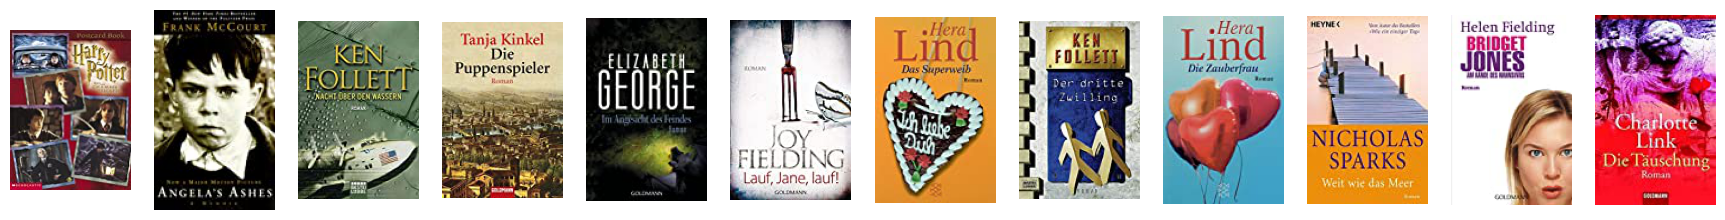

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=len(get_books_by_user_id(user_id)), figsize=(22, 6))

for i, isbn in enumerate(get_books_by_user_id(user_id)):
    r = requests.get(interactions[interactions['ISBN'] == isbn]["picture_url"].tolist()[0], headers=headers)
    im = Image.open(BytesIO(r.content))
    axs[i].imshow(im)
    axs[i].set_axis_off()

plt.show()

# Персональный топ

In [ ]:
# разделяем location на группы
users['Country'] = users['Location'].str.split(', ').str[2]

In [ ]:
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
140627,0151269300,Dutch Uncle,Marilyn Durham,1973,Harcourt,http://images.amazon.com/images/P/0151269300.0...,http://images.amazon.com/images/P/0151269300.0...,http://images.amazon.com/images/P/0151269300.0...
140628,0307161811,The E-Mail Mystery (Mercer Mayer's Lc + the Cr...,Erica Farber,1995,Golden Books,http://images.amazon.com/images/P/0307161811.0...,http://images.amazon.com/images/P/0307161811.0...,http://images.amazon.com/images/P/0307161811.0...
140629,0553157779,"Jack Galaxy, Space Cop",Robert Kraus,1989,Skylark Books,http://images.amazon.com/images/P/0553157779.0...,http://images.amazon.com/images/P/0553157779.0...,http://images.amazon.com/images/P/0553157779.0...
140630,0816737819,Sonic &amp; Knuckles,Michael Teitelbaum,1995,Troll Communications,http://images.amazon.com/images/P/0816737819.0...,http://images.amazon.com/images/P/0816737819.0...,http://images.amazon.com/images/P/0816737819.0...


In [ ]:
def personal_topN(age, location, N = 10):

    personal_users = users[(age-3 <= users['Age']) & (users['Age'] <= age + 3) & (users['Country'] == location.split(', ')[2])]
    user_ids = personal_users['User-ID'].tolist()
    personal_interactions = interactions[interactions['User-ID'].isin(user_ids)]

    book_ratings = personal_interactions.groupby('ISBN')['Book-Rating'].mean().reset_index()


    top_books = book_ratings.sort_values('Book-Rating', ascending=False).head(N)

    personal_top = pd.merge(top_books, books, on='ISBN')[['ISBN', 'Book-Title', 'Book-Author', 'Book-Rating']]
    return personal_top

In [ ]:
user

,User-ID,Location,Age,Country,AgeGroup
201547,201548,"rheinfelden, baden-wuerttemberg, germany",29.0,germany,22-30


In [ ]:
age = user.Age.item()
location = user.Location.item()
personal_topN(age, location)

,ISBN,Book-Title,Book-Author,Book-Rating
0,0316107549,Classics of Western Literature: Bloom County 1...,Berke Breathed,10.0
1,0375815260,Charlie and the Chocolate Factory,ROALD DAHL,10.0
2,0394800303,Dr. Seuss's A B C (I Can Read It All by Myself...,DR SEUSS,10.0
3,0553802518,The Survivors Club,LISA GARDNER,10.0
4,0451410025,I Am the Only Running Footman,Martha Grimes,10.0
5,0671553038,LIFE SUPPORT,Tess Gerritsen,10.0
6,3548600808,Elementarteilchen.,Michel Houellebecq,10.0
7,0316286869,Making Faces,Kevyn Aucoin,10.0
8,0061052507,"Feet of Clay: A Novel of Discworld (Pratchett,...",Terry Pratchett,10.0
9,1551666014,Tomorrow's Promise: Can the Heart Let Go of Ye...,Sandra Brown,10.0


# Метод кластеризации

In [ ]:
# разделяем возраст на группы
bins = [0, 14, 18, 22, 30, 45, 60, 100]
labels = ['0-14', '14-18', '18-22','22-30','30-45','45-60','60+']
users['AgeGroup'] = pd.cut(users['Age'], bins=bins, labels=labels)

# разделяем location на группы
users['Country'] = users['Location'].str.split(', ').str[2]

In [ ]:
def group_topN(ageGroup, country, N = 10):

    personal_users = users[(users['AgeGroup'] == ageGroup) & (users['Country'] == country)]
    user_ids = personal_users['User-ID'].tolist()
    personal_interactions = interactions[interactions['User-ID'].isin(user_ids)]

    book_ratings = personal_interactions.groupby('ISBN')['Book-Rating'].mean().reset_index()


    top_books = book_ratings.sort_values('Book-Rating', ascending=False).head(N)

    personal_top = pd.merge(top_books, books, on='ISBN')[['ISBN', 'Book-Title', 'Book-Author', 'Book-Rating']]
    return personal_top

In [ ]:
user = users[users['User-ID'] == user_id]
group_topN(user.AgeGroup.item(), user.Country.item())

,ISBN,Book-Title,Book-Author,Book-Rating
0,0385335881,Shopaholic Takes Manhattan (Summer Display Opp...,Sophie Kinsella,10.0
1,0811824829,52 Deck Series: 52 Ways to Celebrate Friendship,Lynn Gordon,10.0
2,3492227694,Mariana.,Susanna Kearsley,10.0
3,0413537900,The Secret Diary of Adrian Mole Aged 13 3/4,Sue Townsend,10.0
4,1400031354,Tears of the Giraffe (No.1 Ladies Detective Ag...,Alexander McCall Smith,10.0
5,0395927218,The Namesake,Jhumpa Lahiri,10.0
6,0385336810,Can You Keep a Secret?,Sophie Kinsella,10.0
7,0385336179,Shopaholic Ties the Knot,Sophie Kinsella,10.0
8,0385335482,Confessions of a Shopaholic (Summer Display Op...,SOPHIE KINSELLA,10.0
9,3499137909,Der Plan von der Abschaffung des Dunkels.,Peter Hoeg,10.0


# Совстречаемость

In [ ]:
def also_buy_N(isbn, N = 10):

    chosen_book = interactions[interactions['ISBN'] == isbn][['User-ID', 'Book-Rating']]
    chosen_book.columns = ['User-ID', 'choosen_book_rating']

    book_interactions = interactions[interactions['ISBN'] == isbn]
    user_ids = book_interactions['User-ID'].tolist()
    other_interactions = interactions[(interactions['User-ID'].isin(user_ids)) & (interactions['ISBN'] != isbn)]

    other_interactions = other_interactions.merge(chosen_book, on='User-ID', how='left')


    other_interactions = other_interactions.groupby('ISBN').sum()
    other_interactions['weight'] = (other_interactions['Book-Rating'] + other_interactions['choosen_book_rating']) / 2
    # book_counts = other_interactions.groupby('ISBN').size().reset_index(name='count')
    # book_pairs = pd.merge(book_counts, books, on='ISBN')[['ISBN', 'Book-Title', 'Book-Author', 'count']]
    #book_pairs['weight'] =

    # top_pairs = book_pairs.sort_values('weight', ascending=False).head(N)
    # return book_counts
    return other_interactions['weight'].sort_values(ascending = False).reset_index()['ISBN'].head(N)

In [ ]:
also_buy_N('0385335482')

<ipython-input-200-064b0a16564c>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  other_interactions = other_interactions.groupby('ISBN').sum()


0    0385335881
1    0743418174
2    0312278586
3    0385336179
4    0316666343
5    0786868716
6    0385504209
7    0679746048
8    0142001740
9    0446672211
Name: ISBN, dtype: object

## Проверка

Гарри Поттер

In [ ]:
for i, j in interactions[["ISBN", "Book-Title"]].drop_duplicates().values:
    if "Harry Potter" in j:
        print("ISBN:", i, "\tBook Title:", j)

ISBN: 0439064864 	Book Title: Harry Potter and the Chamber of Secrets (Book 2)
ISBN: 0439139597 	Book Title: Harry Potter and the Goblet of Fire (Book 4)
ISBN: 0590353403 	Book Title: Harry Potter and the Sorcerer's Stone (Book 1)
ISBN: 0439425220 	Book Title: Harry Potter and the Chamber of Secrets Postcard Book
ISBN: 0439136350 	Book Title: Harry Potter and the Prisoner of Azkaban (Book 3)
ISBN: 0439139600 	Book Title: Harry Potter and the Goblet of Fire (Book 4)
ISBN: 0439064872 	Book Title: Harry Potter and the Chamber of Secrets (Book 2)
ISBN: 0439136369 	Book Title: Harry Potter and the Prisoner of Azkaban (Book 3)
ISBN: 0767908473 	Book Title: The Sorcerer's Companion: A Guide to the Magical World of Harry Potter
ISBN: 0972393617 	Book Title: Ultimate Unofficial Guide to the Mysteries of Harry Potter
ISBN: 2070524558 	Book Title: Harry Potter et la chambre des secrets
ISBN: 8478885196 	Book Title: Harry Potter y el prisionero de Azkaban
ISBN: 8478886451 	Book Title: Harry Potter

<ipython-input-200-064b0a16564c>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  other_interactions = other_interactions.groupby('ISBN').sum()


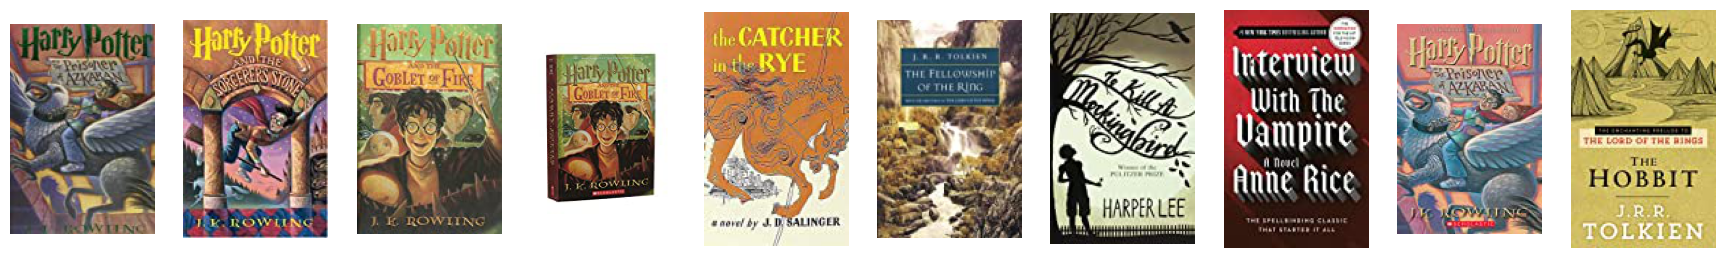

In [ ]:
similar_isbn = also_buy_N('0439064864')
fig, axs = plt.subplots(nrows=1, ncols=len(similar_isbn), figsize=(22, 6))

for i, isbn in enumerate(similar_isbn):
    r = requests.get(interactions[interactions['ISBN'] == isbn]["picture_url"].tolist()[0], headers=headers)
    im = Image.open(BytesIO(r.content))
    axs[i].imshow(im)
    axs[i].set_axis_off()

plt.show()

Стивен Кинг

In [ ]:
books[books['Book-Author'] == 'Stephen King']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
126,0671042858,The Girl Who Loved Tom Gordon,Stephen King,2000,Pocket,http://images.amazon.com/images/P/0671042858.0...,http://images.amazon.com/images/P/0671042858.0...,http://images.amazon.com/images/P/0671042858.0...
229,0451162072,Pet Sematary,Stephen King,1994,Signet Book,http://images.amazon.com/images/P/0451162072.0...,http://images.amazon.com/images/P/0451162072.0...,http://images.amazon.com/images/P/0451162072.0...
346,8484509141,Mientras Escribo,Stephen King,2002,Distribooks,http://images.amazon.com/images/P/8484509141.0...,http://images.amazon.com/images/P/8484509141.0...,http://images.amazon.com/images/P/8484509141.0...
502,0743424425,The Shining,Stephen King,2001,Pocket,http://images.amazon.com/images/P/0743424425.0...,http://images.amazon.com/images/P/0743424425.0...,http://images.amazon.com/images/P/0743424425.0...
881,0743211383,Dreamcatcher,Stephen King,2001,Scribner,http://images.amazon.com/images/P/0743211383.0...,http://images.amazon.com/images/P/0743211383.0...,http://images.amazon.com/images/P/0743211383.0...
...,...,...,...,...,...,...,...,...
131210,3404131509,Popsy und 25 weitere Geschichten nach Mitterna...,Stephen King,1988,LÃ?Â¼bbe,http://images.amazon.com/images/P/3404131509.0...,http://images.amazon.com/images/P/3404131509.0...,http://images.amazon.com/images/P/3404131509.0...
131564,2226036733,Misery,Stephen King,2000,Albin Michel,http://images.amazon.com/images/P/2226036733.0...,http://images.amazon.com/images/P/2226036733.0...,http://images.amazon.com/images/P/2226036733.0...
132934,B0000E63CJ,Dreamcatcher,Stephen King,2001,Scribner,http://images.amazon.com/images/P/B0000E63CJ.0...,http://images.amazon.com/images/P/B0000E63CJ.0...,http://images.amazon.com/images/P/B0000E63CJ.0...
135330,0451145070,Cujo,Stephen King,1986,New Amer Library,http://images.amazon.com/images/P/0451145070.0...,http://images.amazon.com/images/P/0451145070.0...,http://images.amazon.com/images/P/0451145070.0...


<ipython-input-200-064b0a16564c>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  other_interactions = other_interactions.groupby('ISBN').sum()


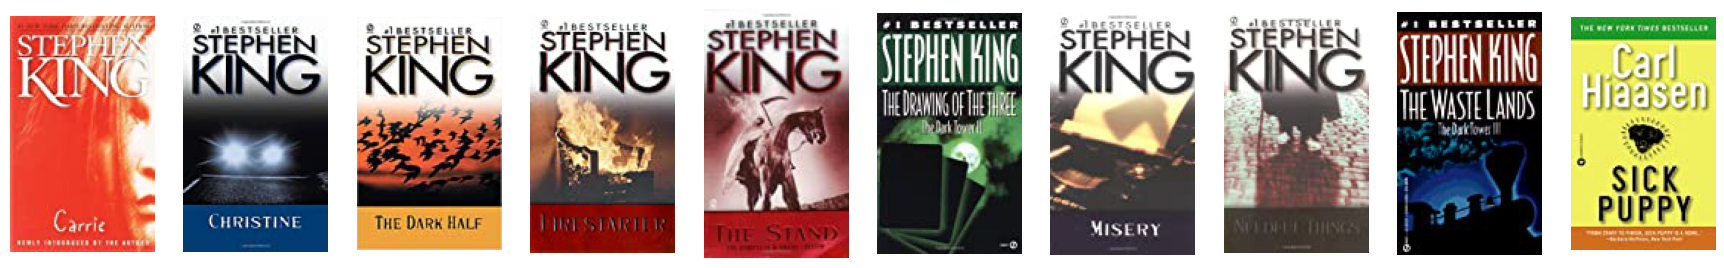

In [ ]:
similar_isbn = also_buy_N('0743424425')
fig, axs = plt.subplots(nrows=1, ncols=len(similar_isbn), figsize=(22, 6))

for i, isbn in enumerate(similar_isbn):
    r = requests.get(interactions[interactions['ISBN'] == isbn]["picture_url"].tolist()[0], headers=headers)
    im = Image.open(BytesIO(r.content))
    axs[i].imshow(im)
    axs[i].set_axis_off()

plt.show()